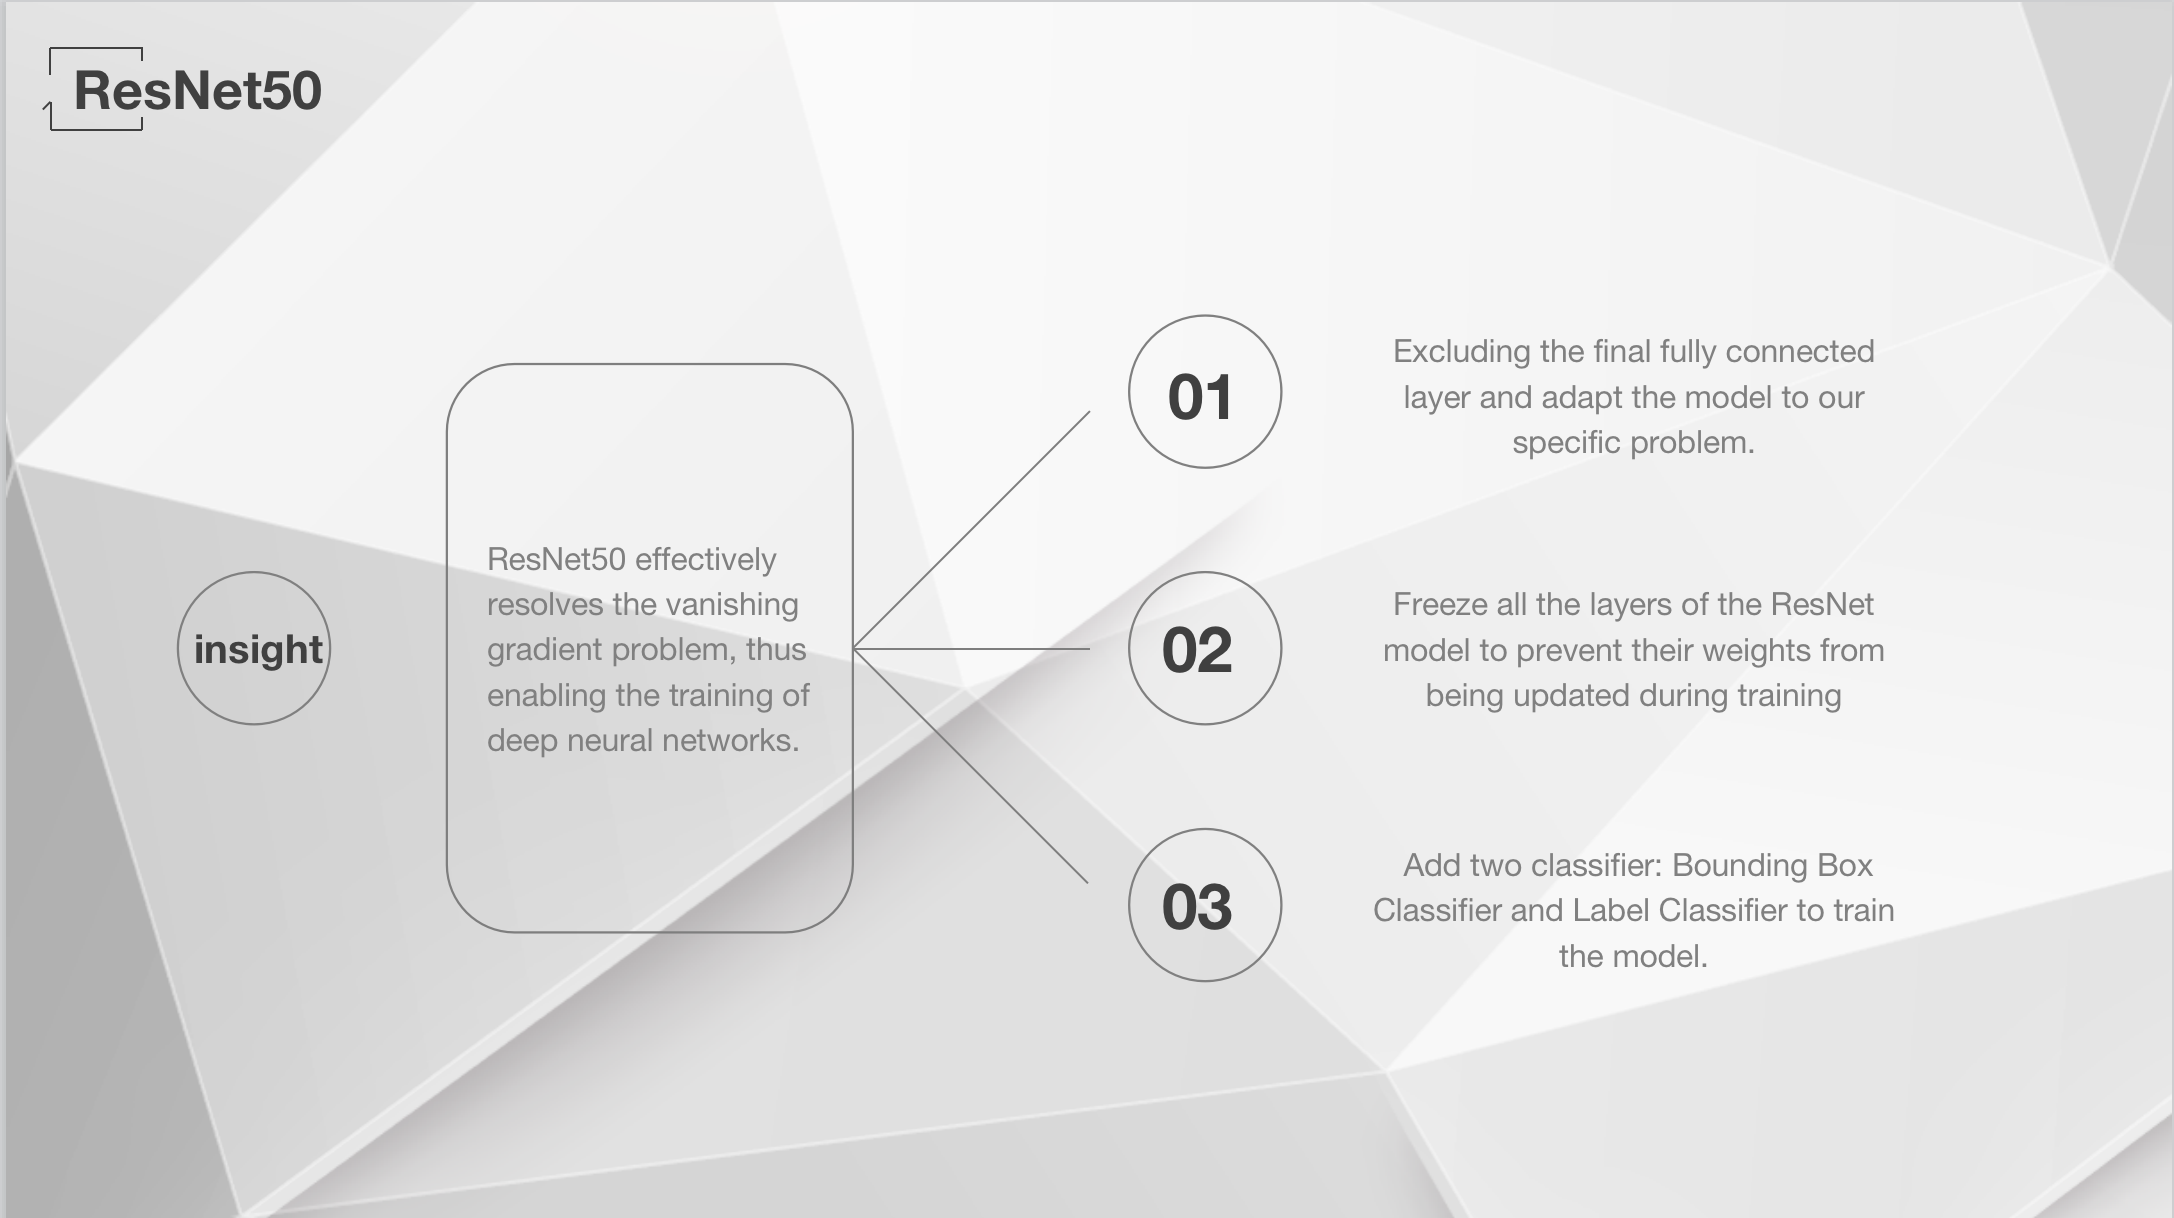

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
# for data processing, i've created pandas dataframe to store all of the data

# create variables for all the path
trainSet = 'train/train'
train_annotation_path = 'train_annotations'
testSet = 'valid/valid'
test_annotation_path = 'valid_annotations'

trainAnnotation = pd.read_json(train_annotation_path)
testAnnotation = pd.read_json(test_annotation_path)

# Define the label mapping
label_map = {1: 'penguin', 2: 'turtle'}

def generateTarget(annotation_file, img_dir):
    df = pd.DataFrame(columns=['filename', 'image', 'label', 'bbox'])
    images = sorted(os.listdir(img_dir))

    for idx, img_name in enumerate(images):
        image_id = int(img_name.split('_')[2].split('.')[0])  # get id from filename
        annotation = annotation_file[annotation_file['image_id'] == image_id].iloc[0]  # find matching annotation

        # get the label and bounding box from the annotation
        label = label_map[annotation['category_id']]  # replace category_id with class name
        bbox = annotation['bbox']

        # Convert bounding box to correct format [xmin, ymin, xmax, ymax]
        xmin, ymin, width, height = bbox
        xmax = xmin + width
        ymax = ymin + height
        bbox = [xmin, ymin, xmax, ymax]

        # load the image
        image_path = os.path.join(img_dir, img_name)
        image = load_img(image_path)

        # get the original image dimensions
        h, w = image.size

        # normalize bounding box coordinates based on original image dimensions
        bbox = [bbox[0] / w, bbox[1] / h, bbox[2] / w, bbox[3] / h]
        bbox = [min(max(coord, 0), 1) for coord in bbox]  # keep each coordinate within [0, 1]

        # resize the image to (255, 255)
        image = image.resize((255, 255))
        image = img_to_array(image) / 255.0  # normalize pixel values to [0, 1]

        # append to the DataFrame
        df.loc[idx] = [img_name, image, label, bbox]

    return df

In [5]:
train_data = generateTarget(trainAnnotation, trainSet)
test_data = generateTarget(testAnnotation, testSet)

train_data.head()

,filename,image,label,bbox
0,image_id_000.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.1859375, 0.0390625, 0.50625, 0.9859375]"
1,image_id_001.jpg,"[[[0.3647059, 0.3647059, 0.3647059], [0.364705...",penguin,"[0.2046875, 0.128125, 0.715625, 0.815625]"
2,image_id_002.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.3515625, 0.465625, 0.6609375, 0.7546875]"
3,image_id_003.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.73125, 0.1703125, 1.0, 0.471875]"
4,image_id_004.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.021875, 0.378125, 0.9765625, 0.61875]"


In [6]:
test_data.head()

,filename,image,label,bbox
0,image_id_000.jpg,"[[[0.56078434, 0.6, 0.69803923], [0.56078434, ...",penguin,"[0.3546875, 0.1453125, 0.8203125, 0.965625]"
1,image_id_001.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.3296875, 0.309375, 0.9984375, 0.7140625]"
2,image_id_002.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.0, 0.3796875, 0.8, 0.796875]"
3,image_id_003.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.2, 0.278125, 0.9140625, 0.83125]"
4,image_id_004.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.2625, 0.2046875, 0.725, 0.9375]"


In [7]:
train_data = generateTarget(trainAnnotation, trainSet)
test_data = generateTarget(testAnnotation, testSet)

# Initialize the binarizer
lb = LabelBinarizer()

# Fit the binarizer and transform the 'label' column to one-hot encoded lists
train_data['one-hot'] = list(lb.fit_transform(train_data['label']))
test_data['one-hot'] = list(lb.transform(test_data['label'])) 

train_data.head()

,filename,image,label,bbox,one-hot
0,image_id_000.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.1859375, 0.0390625, 0.50625, 0.9859375]",[0]
1,image_id_001.jpg,"[[[0.3647059, 0.3647059, 0.3647059], [0.364705...",penguin,"[0.2046875, 0.128125, 0.715625, 0.815625]",[0]
2,image_id_002.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.3515625, 0.465625, 0.6609375, 0.7546875]",[1]
3,image_id_003.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.73125, 0.1703125, 1.0, 0.471875]",[1]
4,image_id_004.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.021875, 0.378125, 0.9765625, 0.61875]",[0]


In [8]:
test_data.head()

,filename,image,label,bbox,one-hot
0,image_id_000.jpg,"[[[0.56078434, 0.6, 0.69803923], [0.56078434, ...",penguin,"[0.3546875, 0.1453125, 0.8203125, 0.965625]",[0]
1,image_id_001.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.3296875, 0.309375, 0.9984375, 0.7140625]",[1]
2,image_id_002.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",turtle,"[0.0, 0.3796875, 0.8, 0.796875]",[1]
3,image_id_003.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.2, 0.278125, 0.9140625, 0.83125]",[0]
4,image_id_004.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",penguin,"[0.2625, 0.2046875, 0.725, 0.9375]",[0]


In [9]:
# Split the train_data DataFrame into train and validation DataFrames
train_data_split, valid_data_split = train_test_split(train_data, test_size=0.1, random_state=42)

print("Training data shape:", train_data_split.shape)
print("Validation data shape:", valid_data_split.shape)

Training data shape: (450, 5)
Validation data shape: (50, 5)


In [10]:
# Initialize the one-hot encoder
enc = OneHotEncoder(sparse_output=False)

# Fit the encoder and transform the 'label' column to one-hot encoded lists
train_data_split['one-hot'] = list(enc.fit_transform(train_data_split['label'].values.reshape(-1, 1)))
valid_data_split['one-hot'] = list(enc.transform(valid_data_split['label'].values.reshape(-1, 1)))

# Extract the data from pandas to numpy, prepare for training
train_images_split = np.stack(train_data_split['image'].values)
train_labels_split = np.array(train_data_split['one-hot'].tolist())
train_bboxes_split = np.stack(train_data_split['bbox'].values)

valid_images_split = np.stack(valid_data_split['image'].values)
valid_labels_split = np.array(valid_data_split['one-hot'].tolist())
valid_bboxes_split = np.stack(valid_data_split['bbox'].values)

In [11]:
# Apply one-hot encoding on the test data
test_data['one-hot'] = list(enc.transform(test_data['label'].values.reshape(-1, 1)))

# Extract data from df to np for the test data
test_images = np.stack(test_data['image'].values)
test_labels = np.array(test_data['one-hot'].tolist())
test_bboxes = np.stack(test_data['bbox'].values)

print(test_labels.shape)

(72, 2)


In [12]:
# implement Resnet50(the backbone of Faster Rcnn) as the base model
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(255, 255, 3)))

# freeze all the layers
for layer in resnet.layers:
    layer.trainable = False

# Get the output of the base model
flatten = Flatten()(resnet.output)

# Set regularization strength
reg_strength = 0.01

# Add regularization to your Dense layers
bbox_classifer = Dense(512, activation="relu", kernel_regularizer=l2(reg_strength))(flatten)
bbox_classifer = Dense(512, activation="relu", kernel_regularizer=l2(reg_strength))(bbox_classifer)
bbox_classifer = Dense(256, activation="relu", kernel_regularizer=l2(reg_strength))(bbox_classifer)
#bbox_classifer = Dense(128, activation="relu", kernel_regularizer=l2(reg_strength))(bbox_classifer)
bbox_classifer = Dense(64, activation="relu", kernel_regularizer=l2(reg_strength))(bbox_classifer)
bbox_classifer = Dense(4, activation="sigmoid", name="bounding_box", kernel_regularizer=l2(reg_strength))(bbox_classifer)

label_classifier = Dense(512, activation="relu", kernel_regularizer=l2(reg_strength))(flatten)
label_classifier = Dropout(0.4)(label_classifier)
label_classifier = Dense(512, activation="relu", kernel_regularizer=l2(reg_strength))(label_classifier)
label_classifier = Dropout(0.4)(label_classifier)
# label_classifier = Dense(256, activation="relu", kernel_regularizer=l2(reg_strength))(label_classifier)
# label_classifier = Dropout(0.5)(label_classifier)
# label_classifier = Dense(32, activation="relu", kernel_regularizer=l2(reg_strength))(label_classifier)
#label_classifier = Dropout(0.5)(label_classifier)
label_classifier = Dense(len(lb.classes_), activation="softmax", name="class_label", kernel_regularizer=l2(reg_strength))(label_classifier)


# put together the model with two heads
model = Model(inputs=resnet.input, outputs=[bbox_classifer, label_classifier])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 261, 261, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
# define hyper parameters
epochs = 25
batch_size = 32
opt = Adam(learning_rate=0.0001)

# Compile the model with the custom optimizer
model.compile(loss={"class_label": "categorical_crossentropy", "bounding_box": "mse"},
              optimizer=opt,
              metrics=["accuracy"])

# Then train the model using the split data
history = model.fit([train_images_split], 
                    {"class_label": train_labels_split, "bounding_box": train_bboxes_split}, 
                    validation_data=([valid_images_split], {"class_label": valid_labels_split, "bounding_box": valid_bboxes_split}),
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/25
15/15 [==============================] - 18s 1s/step - loss: 31.7993 - bounding_box_loss: 0.0358 - class_label_loss: 1.6863 - bounding_box_accuracy: 0.5022 - class_label_accuracy: 0.5622 - val_loss: 25.8272 - val_bounding_box_loss: 0.0328 - val_class_label_loss: 1.3150 - val_bounding_box_accuracy: 0.6400 - val_class_label_accuracy: 0.5000
Epoch 2/25
15/15 [==============================] - 16s 1s/step - loss: 23.3328 - bounding_box_loss: 0.0272 - class_label_loss: 1.8264 - bounding_box_accuracy: 0.6356 - class_label_accuracy: 0.5267 - val_loss: 18.9056 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.5297 - val_bounding_box_accuracy: 0.6600 - val_class_label_accuracy: 0.7400
Epoch 3/25
15/15 [==============================] - 15s 1s/step - loss: 17.8779 - bounding_box_loss: 0.0233 - class_label_loss: 1.0744 - bounding_box_accuracy: 0.6289 - class_label_accuracy: 0.5756 - val_loss: 15.8602 - val_bounding_box_loss: 0.0249 - val_class_label_loss: 0.6613 - val_bounding_

In [21]:
# save the model
model.save('SEmodel')

INFO:tensorflow:Assets written to: SEmodel/assets


INFO:tensorflow:Assets written to: SEmodel/assets


In [48]:
# Predict labels and bounding boxes on the test set
preds = model.predict([test_images])

# get class predictions (take the argmax of the predictions)
class_preds = np.argmax(preds[1], axis=1)

# get ground truth labels
true_labels = np.argmax(test_labels, axis=1)

# generate classification report
report = classification_report(true_labels, class_preds, target_names=enc.categories_[0])
print(report)

3/3 [==============================] - 3s 719ms/step
              precision    recall  f1-score   support

     penguin       0.66      0.75      0.70        36
      turtle       0.71      0.61      0.66        36

    accuracy                           0.68        72
   macro avg       0.68      0.68      0.68        72
weighted avg       0.68      0.68      0.68        72



In [23]:
# get bounding box predictions
bbox_preds = preds[0]

# calculate centers of predicted and true bounding boxes
pred_centers = np.column_stack([(bbox_preds[:, 0] + bbox_preds[:, 2]) / 2,
                                (bbox_preds[:, 1] + bbox_preds[:, 3]) / 2])
true_centers = np.column_stack([(test_bboxes[:, 0] + test_bboxes[:, 2]) / 2,
                                (test_bboxes[:, 1] + test_bboxes[:, 3]) / 2])

# calculate Euclidean distances
distances = euclidean_distances(true_centers, pred_centers)
mean_dist = np.mean(distances)
std_dist = np.std(distances)
def iou(box1, box2):

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    iou = inter_area / union_area

    return iou

# Calculate the IoU for each bounding box
ious = [iou(test_bboxes[i], bbox_preds[i]) for i in range(len(test_bboxes))]

mean_iou = np.mean(ious)
std_iou = np.std(ious)

print(f"Mean Euclidean distance: {mean_dist}")
print(f"Stddev Euclidean distance: {std_dist}")
print(f"Mean IoU: {mean_iou}")
print(f"Stddev IoU: {std_iou}")

Mean Euclidean distance: 0.14179341859185687
Stddev Euclidean distance: 0.07757349101794146
Mean IoU: 0.35925939218062264
Stddev IoU: 0.16569578202672217


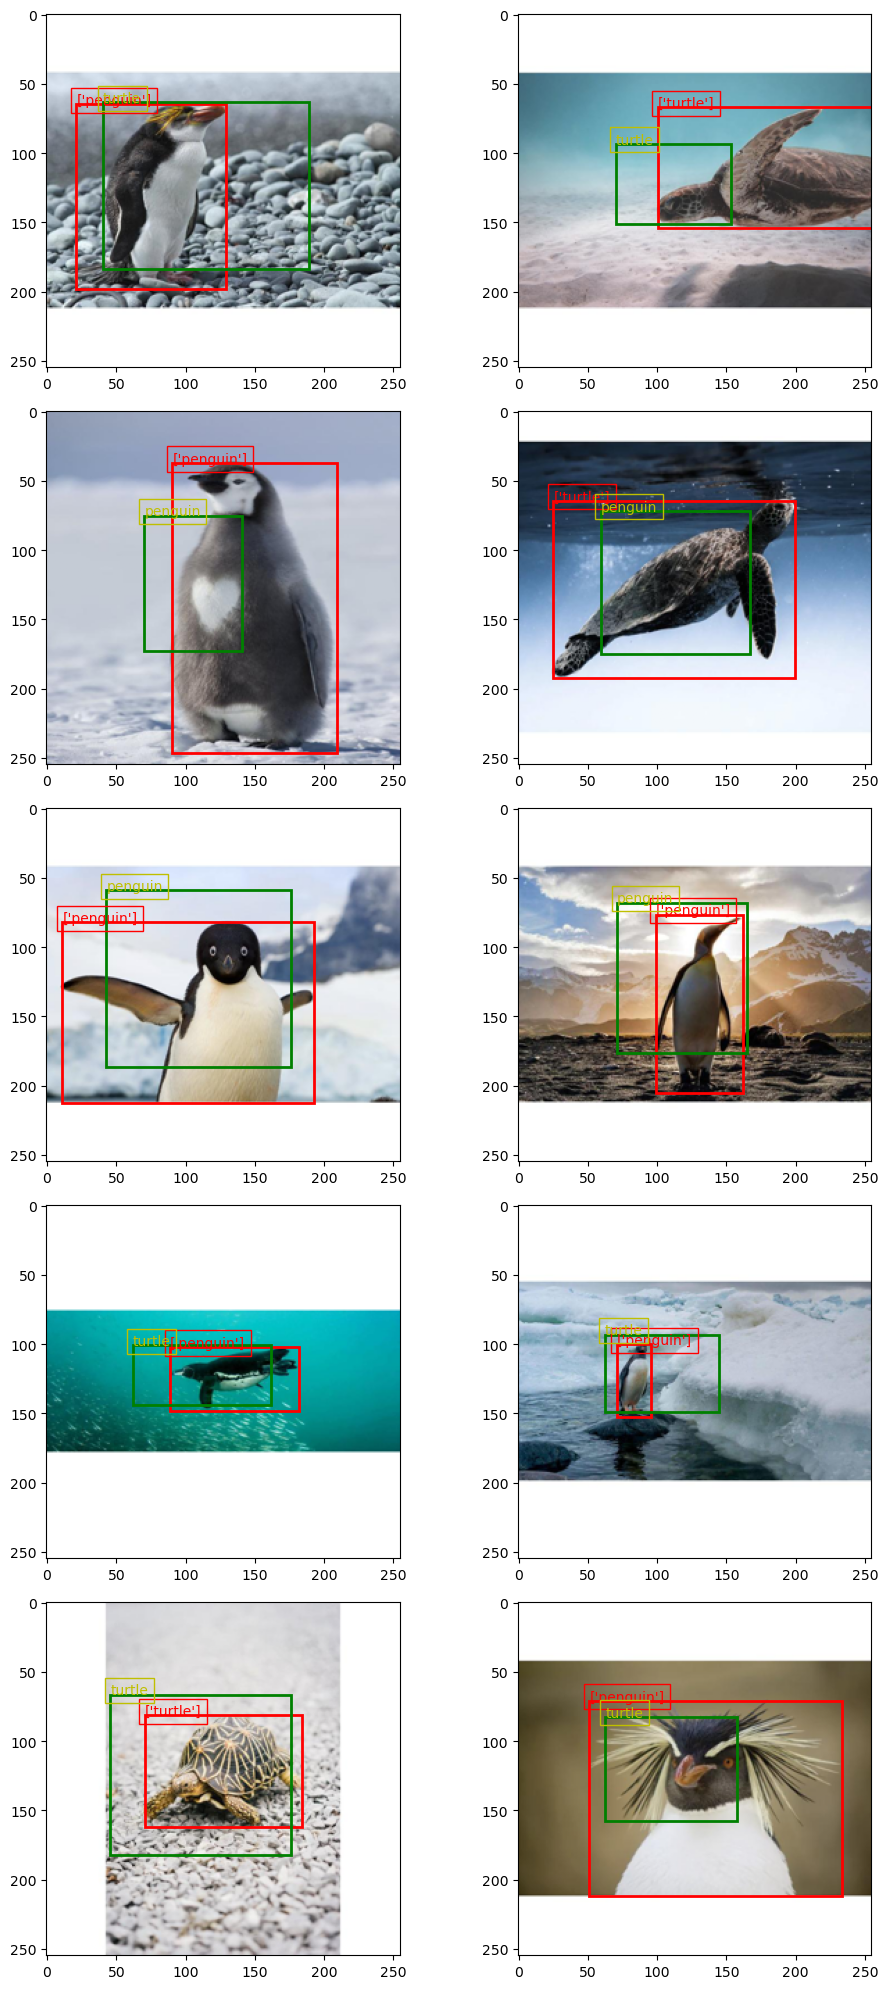

In [49]:
# choose 10 random images from the test set
indices = np.random.choice(len(test_images), 10)

# create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, idx in enumerate(indices):
    # get the image and its size
    img = test_images[idx]
    img_height, img_width, _ = img.shape

    # show the image
    ax = axs[i // 2, i % 2]  # select the current subplot
    ax.imshow(img)

    # draw the true bounding box
    true_bbox = patches.Rectangle((test_bboxes[idx][0] * img_width, test_bboxes[idx][1] * img_height), 
                                  (test_bboxes[idx][2] - test_bboxes[idx][0]) * img_width, 
                                  (test_bboxes[idx][3] - test_bboxes[idx][1]) * img_height, 
                                  linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(true_bbox)

    # draw the predicted bounding box
    pred_bbox = patches.Rectangle((bbox_preds[idx][0] * img_width, bbox_preds[idx][1] * img_height), 
                                  (bbox_preds[idx][2] - bbox_preds[idx][0]) * img_width, 
                                  (bbox_preds[idx][3] - bbox_preds[idx][1]) * img_height, 
                                  linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(pred_bbox)

    # show the true and predicted class labels
    class_mapping = {0: 'penguin', 1: 'turtle'}
    true_label = enc.inverse_transform(test_labels[idx].reshape(1, -1))[0]
    pred_label = class_mapping[class_preds[idx]]

    # show the labels on the bounding boxes with corresponding colors
    ax.text(test_bboxes[idx][0] * img_width, test_bboxes[idx][1] * img_height, true_label, 
            color='r', bbox=dict(facecolor='none', edgecolor='r'))
    ax.text(bbox_preds[idx][0] * img_width, bbox_preds[idx][1] * img_height, pred_label, 
            color='y', bbox=dict(facecolor='none', edgecolor='y'))

plt.tight_layout()
plt.show()